In [1]:
ls

49.py  49.yaml  mprofile_20180228232323.dat  viz-memory.ipynb


In [4]:
cat mprofile_20180228232323.dat

CMDLINE /home/eduardo/miniconda3/envs/yass/bin/python 49.py
MEM 0.753906 1519878203.2202
MEM 12.949219 1519878203.3205
MEM 22.214844 1519878203.4208
MEM 32.621094 1519878203.5211
MEM 34.566406 1519878203.6215
MEM 42.230469 1519878203.7218
MEM 64.210938 1519878203.8222
MEM 105.589844 1519878203.9225
MEM 115.261719 1519878204.0228
MEM 120.777344 1519878204.1231
MEM 125.363281 1519878204.2235
MEM 130.132812 1519878204.3238
MEM 135.515625 1519878204.4242
MEM 145.417969 1519878204.5246
MEM 155.449219 1519878204.6250
MEM 159.031250 1519878204.7254
MEM 170.902344 1519878204.8258
MEM 178.710938 1519878204.9261
MEM 185.437500 1519878205.0264
MEM 186.820312 1519878205.1269
MEM 195.332031 1519878205.2272
MEM 206.105469 1519878205.3275
MEM 214.046875 1519878205.4278
MEM 214.550781 1519878205.5281
MEM 214.566406 1519878205.6283
MEM 217.628906 1519878205.7287
MEM 274.363281 1519878205.8291
MEM 297.078125 1519878205.9295
MEM 342.179688 1519878206.0299
MEM 386.769531 1519878206.1303
MEM 436.753906 151

In [31]:
from collections import defaultdict

In [32]:
def read_mprofile_file(filename):
    """Read an mprofile file and return its content.
    Returns
    =======
    content: dict
        Keys:
        - "mem_usage": (list) memory usage values, in MiB
        - "timestamp": (list) time instant for each memory usage value, in
            second
        - "func_timestamp": (dict) for each function, timestamps and memory
            usage upon entering and exiting.
        - 'cmd_line': (str) command-line ran for this profile.
    """
    func_ts = {}
    mem_usage = []
    timestamp = []
    children  = defaultdict(list)
    cmd_line = None
    f = open(filename, "r")
    for l in f:
        if l == '\n':
            raise ValueError('Sampling time was too short')
        field, value = l.split(' ', 1)
        if field == "MEM":
            # mem, timestamp
            values = value.split(' ')
            mem_usage.append(float(values[0]))
            timestamp.append(float(values[1]))

        elif field == "FUNC":
            values = value.split(' ')
            f_name, mem_start, start, mem_end, end = values[:5]
            ts = func_ts.get(f_name, [])
            ts.append([float(start), float(end),
                       float(mem_start), float(mem_end)])
            func_ts[f_name] = ts

        elif field == "CHLD":
            values = value.split(' ')
            chldnum = values[0]
            children[chldnum].append(
                (float(values[1]), float(values[2]))
            )

        elif field == "CMDLINE":
            cmd_line = value
        else:
            pass
    f.close()

    return {"mem_usage": mem_usage, "timestamp": timestamp,
            "func_timestamp": func_ts, 'filename': filename,
            'cmd_line': cmd_line, 'children': children}


In [33]:
def plot_file(filename, index=0, timestamps=True, children=True, options=None):
    try:
        import pylab as pl
    except ImportError as e:
        print("matplotlib is needed for plotting.")
        print(e)
        sys.exit(1)
    import numpy as np  # pylab requires numpy anyway
    mprofile = read_mprofile_file(filename)

    if len(mprofile['timestamp']) == 0:
        print('** No memory usage values have been found in the profile '
              'file.**\nFile path: {0}\n'
              'File may be empty or invalid.\n'
              'It can be deleted with "mprof rm {0}"'.format(
            mprofile['filename']))
        sys.exit(0)

    # Merge function timestamps and memory usage together
    ts = mprofile['func_timestamp']
    t = mprofile['timestamp']
    mem = mprofile['mem_usage']
    chld = mprofile['children']

    if len(ts) > 0:
        for values in ts.values():
            for v in values:
                t.extend(v[:2])
                mem.extend(v[2:4])

    mem = np.asarray(mem)
    t = np.asarray(t)
    ind = t.argsort()
    mem = mem[ind]
    t = t[ind]

    # Plot curves
    global_start = float(t[0])
    t = t - global_start

    max_mem = mem.max()
    max_mem_ind = mem.argmax()

    all_colors = ("c", "y", "g", "r", "b")
    mem_line_colors = ("k", "b", "r", "g", "c", "y", "m")
    mem_line_label = time.strftime("%d / %m / %Y - start at %H:%M:%S",
                                   time.localtime(global_start)) \
                     + ".{0:03d}".format(int(round(math.modf(global_start)[0] * 1000)))

    pl.plot(t, mem, "+-" + mem_line_colors[index % len(mem_line_colors)],
            label=mem_line_label)

    bottom, top = pl.ylim()
    bottom += 0.001
    top -= 0.001

    # plot children, if any
    if len(chld) > 0 and children:
        cmpoint = (0,0) # maximal child memory

        for idx, (proc, data) in enumerate(chld.items()):
            # Create the numpy arrays from the series data
            cts  = np.asarray([item[1] for item in data]) - global_start
            cmem = np.asarray([item[0] for item in data])

            # Plot the line to the figure
            pl.plot(cts, cmem, "+-"  + mem_line_colors[(idx+1) % len(mem_line_colors)],
                     label="child {}".format(proc))

            # Detect the maximal child memory point
            cmax_mem = cmem.max()
            if cmax_mem > cmpoint[1]:
                cmpoint = (cts[cmem.argmax()], cmax_mem)

        # Add the marker lines for the maximal child memory usage
        pl.vlines(cmpoint[0], pl.ylim()[0]+0.001, pl.ylim()[1] - 0.001, 'r', '--')
        pl.hlines(cmpoint[1], pl.xlim()[0]+0.001, pl.xlim()[1] - 0.001, 'r', '--')

    # plot timestamps, if any
    if len(ts) > 0 and timestamps:
        func_num = 0
        for f, exec_ts in ts.items():
            for execution in exec_ts:
                add_brackets(execution[:2], execution[2:], xshift=global_start,
                             color=all_colors[func_num % len(all_colors)],
                             label=f.split(".")[-1]
                                   + " %.3fs" % (execution[1] - execution[0]), options=options)
            func_num += 1

    if timestamps:
        pl.hlines(max_mem,
                  pl.xlim()[0] + 0.001, pl.xlim()[1] - 0.001,
                  colors="r", linestyles="--")
        pl.vlines(t[max_mem_ind], bottom, top,
                  colors="r", linestyles="--")
        return mprofile

{'children': defaultdict(list, {}),
 'cmd_line': '/home/eduardo/miniconda3/envs/yass/bin/python 49.py\n',
 'filename': 'mprofile_20180228232323.dat',
 'func_timestamp': {},
 'mem_usage': [0.753906,
  12.949219,
  22.214844,
  32.621094,
  34.566406,
  42.230469,
  64.210938,
  105.589844,
  115.261719,
  120.777344,
  125.363281,
  130.132812,
  135.515625,
  145.417969,
  155.449219,
  159.03125,
  170.902344,
  178.710938,
  185.4375,
  186.820312,
  195.332031,
  206.105469,
  214.046875,
  214.550781,
  214.566406,
  217.628906,
  274.363281,
  297.078125,
  342.179688,
  386.769531,
  436.753906,
  488.0625,
  539.410156,
  589.332031,
  642.03125,
  694.71875,
  746.003906,
  794.640625,
  831.546875,
  841.539062,
  827.261719,
  544.550781,
  850.945312,
  843.601562,
  600.203125,
  854.746094,
  749.308594,
  670.378906,
  858.21875,
  673.070312,
  671.171875,
  872.320312,
  299.710938,
  794.96875,
  882.890625,
  415.796875,
  851.4375,
  844.355469,
  531.847656,
  860.2

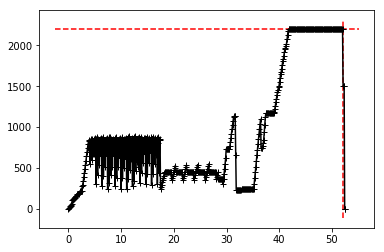

In [36]:
import time
import math
plot_file('mprofile_20180228232323.dat')

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('mprofile_20180228232323.dat', sep=' ',
                 names=['mem', 'usage', 'time'],
                skiprows=[0])

In [13]:
df.head()

,mem,time,usage
0,MEM,0.753906,1.519878e+09
1,MEM,12.949219,1.519878e+09
2,MEM,22.214844,1.519878e+09
3,MEM,32.621094,1.519878e+09
4,MEM,34.566406,1.519878e+09


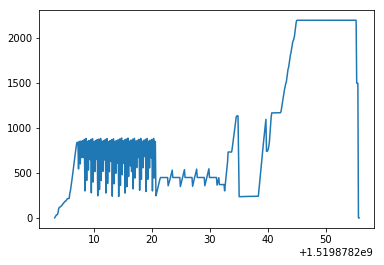

In [20]:
plt.plot(df.time, df.usage)

In [22]:
df.usage

0         0.753906
1        12.949219
2        22.214844
3        32.621094
4        34.566406
5        42.230469
6        64.210938
7       105.589844
8       115.261719
9       120.777344
10      125.363281
11      130.132812
12      135.515625
13      145.417969
14      155.449219
15      159.031250
16      170.902344
17      178.710938
18      185.437500
19      186.820312
20      195.332031
21      206.105469
22      214.046875
23      214.550781
24      214.566406
25      217.628906
26      274.363281
27      297.078125
28      342.179688
29      386.769531
          ...     
494    2196.917969
495    2196.917969
496    2196.917969
497    2196.917969
498    2196.917969
499    2196.917969
500    2196.917969
501    2196.917969
502    2196.917969
503    2196.917969
504    2196.917969
505    2196.917969
506    2196.917969
507    2196.917969
508    2196.917969
509    2196.917969
510    2196.917969
511    2196.917969
512    2196.917969
513    2196.917969
514    2196.917969
515    2196.